In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from consts import * 
from transform2D import *
from astra_modules import *

from scipy import optimize
from scipy.integrate import ode
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
import re
mpl.rcParams.update({'font.size': 16})

## 打开工作目录

In [28]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Merger'
os.chdir(workdir)

## 定义后处理函数

In [2]:
f = lambda x,a,b:a*x+b
f1 = lambda x,a,b:a*x+b
f2 = lambda x,a,b,c:a*x**2+b*x+c
f3 = lambda x,a,b,c,d:a*x**3+b*x**2+c*x+d

def lsq(x,y):
    ''' Least square fitting
        Input: x-y coordinates to be fitted
        Output: [a b r], a is slope'''
    xc,yc=np.mean(x),np.mean(y)
    xyc=np.mean(x*y)
    x2c=np.mean(x*x)
    y2c=np.mean(y*y)
    
    a=(xyc-xc*yc)/(x2c-xc**2)
    b=yc-a*xc
    r=np.abs((xyc-xc*yc)/np.sqrt((x2c-xc**2)*(y2c-yc**2)))
    return np.array([a,b,r])

def nemixrms(x,xp):
    '''input: x-xp phase space
       output: emittance'''
    return np.sqrt(np.var(x)*np.var(xp)-np.mean((x-np.mean(x))*(xp-np.mean(xp)))**2)

def astra_post(data):
    '''input data: x y z Px Py Pz
       output: avgz nemit_x nemit_y std_x std_y std_z Ekin std_Ekin nemit_z Npart r2 xavg yavg'''

    x,y,z=data[:,0],data[:,1],data[:,2]
    bgx,bgy,bgz=data[:,3]/511000,data[:,4]/511000,data[:,5]/511000
    gamma=np.sqrt(1+bgx**2+bgy**2+bgz**2)
    Ek=np.sqrt(1+bgx**2+bgy**2+bgz**2)*0.511-0.511
    
    rr=lsq(z,bgz/gamma)
    
    return np.array([np.mean(z),nemixrms(x,bgx)*1e6,nemixrms(y,bgy)*1e6,np.std(x)*1e3,np.std(y)*1e3,np.std(z)*1e3,\
                     np.mean(Ek),np.std(Ek)*1e3,nemixrms(z,Ek)*1e6,len(x),rr[2],np.mean(x),np.mean(y)])                 

def astra_iter_dir(ndir,r1=0.85,r0=0):
    '''对给定文件夹下所有ast.xxxx.001文件运行后处理程序astra_post，并将结果进行保存
       r1和r0分别是待统计粒子的百分比和统计的起始点
    '''    
    ss=''
    sep=os.sep
    for rt, dirs, files in os.walk(ndir):
        for f in files:
            pos=re.match(r'ast.[\d]+.001',f)
            if pos:
                fname=ndir+sep+f
                data=np.loadtxt(fname)
                by=2
                
                zm,pm=data[0,2],data[0,5]
                data[1:,2]=data[1:,2]+zm
                data[1:,5]=data[1:,5]+pm
                
                cc=len(data[:,0])
                c0=(int)(cc-cc*r0)-1
                c1=c0-(int)(cc*r1)
                #print c0,c1
                
                #data=data[data[:,by].argsort()]
                #data=data[c1:c0]
                
                r=astra_post(data)
                for k in np.arange(len(r)):
                    ss=ss+str.format('%12.4E' % r[k])
                ss=ss+'\n'
    
    rr=(int)(r1*100)
    f = open(ndir+sep+'nemit'+`rr`+'.dat', 'w')
    f.write(ss)
    f.close()

0.954402653098
[  1.51516292e+03   5.64957917e-01   1.43752771e-01]


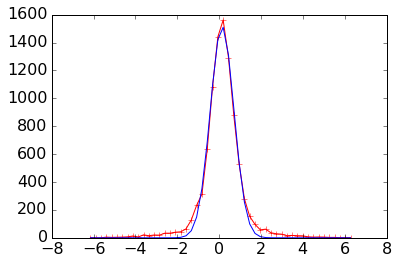

In [109]:
workdir='E:\\Lixiangkun\\Work\\FEL-THz-exp\\20160719\\YAG1-210pC\\305.41Gs'
os.chdir(workdir)

fname=str.format('ast.0105.001')
data=np.loadtxt(fname)
data=data[data[:,9]==5]

print np.std(data[:,0])*1e3
count, bins = np.histogram(data[:,0],50)

cc=1e3 # m->mm

rr=[]
nn=len(count)
for i in np.arange(nn):
    rr.append([bins[i+1]*cc,count[i]])
rr=np.array(rr)

g_fit=lambda x,a,b,c:a*np.exp(-(x-c)**2/2.0/b**2)
popt,pcov=optimize.curve_fit(g_fit,rr[:,0],rr[:,1],(200,3,0))
print popt
plt.plot(rr[:,0],rr[:,1],'r+-')
plt.plot(rr[:,0],g_fit(rr[:,0],popt[0],popt[1],popt[2]),'b-')

In [5]:
# 插值获得某一位置的束流参数
def interp_beam_para(dirname,pos=1.0):
    sep=os.sep
    x=re.findall(r'[\d.]+',dirname)
    if x:
        data=np.loadtxt(dirname+sep+'ast.Xemit.001')
        if len(data)>0:
            ff=interp1d(data[:,0],data[:,3])
            xrms=ff(pos).reshape((1))
            ff=interp1d(data[:,0],data[:,5])
            xemi=ff(pos).reshape((1))
        data=np.loadtxt(dirname+sep+'ast.Yemit.001')
        if len(data)>0:
            ff=interp1d(data[:,0],data[:,3])
            yrms=ff(pos).reshape((1))
            ff=interp1d(data[:,0],data[:,5])
            yemi=ff(pos).reshape((1))
        data=np.loadtxt(dirname+sep+'ast.Zemit.001')
        if len(data)>0:
            ff=interp1d(data[:,0],data[:,3])
            zrms=ff(pos).reshape((1))
            ff=interp1d(data[:,0],data[:,4])
            del_E=ff(pos).reshape((1))
            ff=interp1d(data[:,0],data[:,2])
            E_kin=ff(pos).reshape((1))
        a=[pos,xemi[0],yemi[0],xrms[0],yrms[0],zrms[0],E_kin[0],del_E[0]]
        for i in np.arange(len(x)):
            a.append(float(x[i]))
        return a
    return []
#interp_beam_para('120deg',2.4525)

In [3]:
workdir='E:\\Lixiangkun\\Work\\FEL-THz-exp\\20160719\\YAG1-1mm'
os.chdir(workdir)

In [6]:
pos=1.05
rr=[]
for rt, dirs, files in os.walk('./'):
    for d in dirs:
        a=interp_beam_para(d,pos)
        if len(a)>0:
            rr.append(a)
        #break
rr=np.array(rr)
#print rr
np.savetxt('beam.dat',rr,fmt='%12.4f')

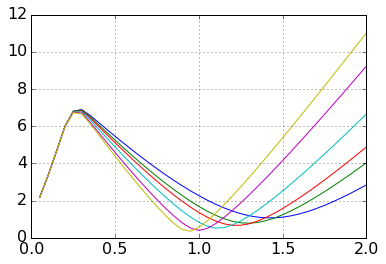

In [8]:
workdir='E:\\Lixiangkun\\Work\\FEL-THz-exp\\20160719\\YAG1'
os.chdir(workdir)

fig,axes=plt.subplots()
Bz1=np.array([287.0593, 290.9521, 293.1765, 297.0692, 302.0741, 305.4107])
for v1 in Bz1:
    fname=str.format('%.2fGs/ast.Xemit.001' % (v1))
    data=np.loadtxt(fname)
    
    #data=data[data[:,9]==5]
    axes.plot(data[:,0],data[:,3])
axes.grid()

## 后处理：计算某一条件下所有位置的束流参数

In [7]:
workdir="E:\\Lixiangkun\\Work\\FEL-THz-exp\\20160719\\YAG1\\287.06Gs" 
os.chdir(workdir)
#astra_iter_dir(subdir,1,0)

In [10]:
ss=''

subdir="./" 
root = workdir+os.sep+subdir

for rt, dirs, files in os.walk(root):
    for f in files:
        pos=re.match(r'ast.[\d]+.001',f)
        if pos:
            fname=subdir+os.sep+f
            data=np.loadtxt(fname)
            by=2
    
            zm,pm=data[0,2],data[0,5]
            data[1:,2]=data[1:,2]+zm
            data[1:,5]=data[1:,5]+pm
            
            data=data[data[:,9]==5]
            #data=data[data[:,by].argsort()]
            #data=data[0:9999]
            #print len(data[:,0])
            
            #x,y=data[:,2],data[:,5]
            #r=lsq(x,y)
            
            r=astra_post(data)
            for k in np.arange(len(r)):
                ss=ss+str.format('%12.4E' % r[k])
            ss=ss+'\n'

9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053
9053


In [9]:
f = open(subdir+os.sep+'nemit100.dat', 'w')
f.write(ss)
f.close()

## 纵向分布拟合

[ 90793328.05743764  -9096406.85493972]


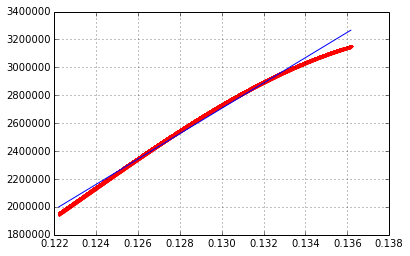

0.999247513972
[  9.07933281e+07  -9.09640686e+06   9.96244445e-01]


In [47]:
datafile='1.00_1.00_1.00/ast.0120.001'
data=np.loadtxt(datafile)
by=2

zm,pm=data[0,2],data[0,5]
data[1:,2]=data[1:,2]+zm
data[1:,5]=data[1:,5]+pm

data=data[data[:,by].argsort()]
data=data[3500:9999]

x,y=data[:,2],data[:,5]
popt, pcov = curve_fit(f, x, y)
print popt

a,b=popt[0],popt[1]
aa,ab,ba,bb=pcov[0,0],pcov[0,1],pcov[1,0],pcov[1,1]

plt.plot(data[:,2],data[:,5],'.r',x,f(x,a,b),'-b')
plt.grid()
plt.show()

print ab*ba/aa/bb
print lsq(x,y)

## 绘制统计分布曲线及拟合

In [3]:
subdir='1.25MV_130deg_300G_100G_180G_125deg_205deg_16MV'
workdir='D:\\Desktop\\THz-FEL\\10ps\\'+subdir
os.chdir(workdir)

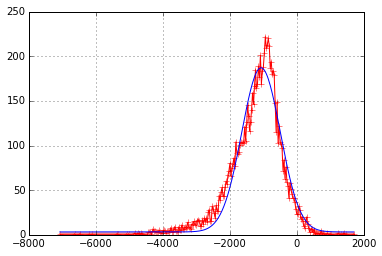

[  183.9042487    576.22235278 -1064.19451215     3.18150333]
777.310876077


In [7]:
data=np.loadtxt('ast.0390.001',skiprows=0)

#data[1:,2]=data[1:,2]+data[0,2]
#data[1:,5]=data[1:,5]+data[0,5]

#data=data[data[:,5]>0]

data[0,2]=0
xx=data[:,2]
#xx=np.sqrt(data[:,3]**2+data[:,4]**2+data[:,5]**2+0.511e6**2)/1e6-0.511
#xx=data[:,7]*2.856e9*360

#gamma=np.mean(data[:,6])
#bg=np.sqrt(gamma**2-1)
#print bg

#xx,xp=data[:,0],data[:,3]/data[:,5]
#xemi=nemixrms(xx,xp)*1e6
#print xemi,xemi*bg

#count, bins, ignored = plt.hist(xx,100)
#plt.show()

count, bins = np.histogram(xx,300)
#print bins[1]-bins[0]

cc=1./3e8*1e15 # m->fs

rr=[]
nn=len(count)
for i in np.arange(nn):
    rr.append([bins[i+1]*cc,count[i]])
rr=np.array(rr)

g_fit=lambda x,a,b,c,d:a*np.exp(-(x-c)**2/2.0/b**2)+d
popt,pcov=optimize.curve_fit(g_fit,rr[:,0],rr[:,1],(300,1e-4*cc,-1000,0))
plt.plot(rr[:,0],rr[:,1],'r+-')
plt.plot(rr[:,0],g_fit(rr[:,0],popt[0],popt[1],popt[2],popt[3]),'b-')
#plt.axis([-1000,1000,0,1200])
plt.grid()
plt.show()

print popt
print np.std(xx)*cc
#print rr
#np.savetxt('z.dat',rr,fmt='%12.4f')

data=np.array([rr[:,0],rr[:,1],g_fit(rr[:,0],popt[0],popt[1],popt[2],popt[3])]).T
np.savetxt('z@5.0m.dat',data,fmt='%.4E')

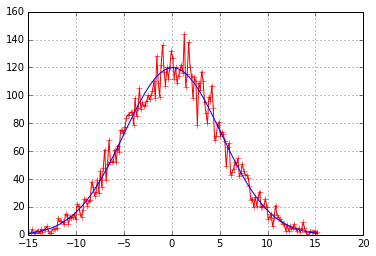

[  1.20233863e+02   5.08199599e+00   8.20218303e-02  -4.50164709e-01]
4.96722608972


In [9]:
data=np.loadtxt('DCgun.ini',skiprows=0)

#data[1:,2]=data[1:,2]+data[0,2]
#data[1:,5]=data[1:,5]+data[0,5]

#data=data[data[:,5]>0]

data[0,6]=0
xx=data[:,6]

count, bins = np.histogram(xx,200)
#print bins[1]-bins[0]

cc=1e3 #1./3e8*1e15 # m->fs

rr=[]
nn=len(count)
for i in np.arange(nn):
    rr.append([bins[i+1]*cc,count[i]])
rr=np.array(rr)

g_fit=lambda x,a,b,c,d:a*np.exp(-(x-c)**2/2.0/b**2)+d
popt,pcov=optimize.curve_fit(g_fit,rr[:,0],rr[:,1],(100,1e-3*cc,1,0))
plt.plot(rr[:,0],rr[:,1],'r+-')
plt.plot(rr[:,0],g_fit(rr[:,0],popt[0],popt[1],popt[2],popt[3]),'b-')
#plt.axis([-1000,1000,0,1200])
plt.grid()
plt.show()

print popt
print np.std(xx)*cc

data=np.array([rr[:,0],rr[:,1],g_fit(rr[:,0],popt[0],popt[1],popt[2],popt[3])]).T
#np.savetxt('z@5.0m.dat',data,fmt='%.4E')

### 偏转铁极面前后各增加50mm，计算起点至终点的水平距离

In [34]:
rr=596
alp=5./180*np.pi
dd=50
LL=dd+2*rr*np.sin(alp/2.)*np.cos(alp/2.)+dd*np.cos(alp)
print LL+8.2278e3
print 8.4-LL*1e-3-8.2278

8379.55455758
0.0204454424178


## Astra.Aperture

In [11]:
workdir='D:\\Desktop\\THz-FEL\\10ps\\Part4\\field-maps'
os.chdir(workdir)

In [29]:
aperture=[] # 第一列长度:m，第二列半径:mm
aperture.append([0.132-0.0205,17.5])
aperture.append([0.1776,17.5])
aperture.append([0.568,17.5])
aperture.append([0.1255,31.5])
aperture.append([0.097,31.5])
aperture.append([0.084,31.5])
aperture.append([0.05,31.5])
aperture.append([0.5,75])
aperture.append([0.015,66.5])

aperture=np.array(aperture)

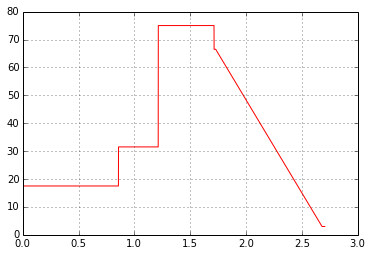

In [30]:
rr=[]
pos=0
[length,rad]=aperture[0]
rr.append([pos,rad])
for i in np.arange(len(aperture)):
    [length,rad]=aperture[i]
    pos=pos+0.001
    rr.append([pos,rad])
    pos=pos+length-0.001
    rr.append([pos,rad])
rr.append([pos+0.953,2.98])
rr.append([pos+0.953+0.025,2.98])
rr=np.array(rr)
plt.plot(rr[:,0],rr[:,1],'r-')
plt.grid()
plt.show()
np.savetxt('aperture.dat',rr,fmt='%12.4E%12.4E')

## Astra -> TRANSPORT

TRANSPORT的输入参数格式：

- x/cm, theta/mrad, y/cm, phi/mrad, l/cm, delta/%, P0/(GeV/c)

\begin{equation}
  
\end{equation}

In [2]:
workdir='D:\\Desktop\\THz-FEL\\10ps\\Transport'
os.chdir(workdir)

In [6]:
data=np.loadtxt('ast.0480.001')
data[0,2]=0
#data[1:,2]=data[1:,2]+data[0,2]
data[1:,5]=data[1:,5]+data[0,5]

data[:,0]=data[:,0]*100 # x: m->cm
data[:,1]=data[:,1]*100 # y: m->cm
data[:,2]=data[:,2]*100 # z: m->cm

data[:,6]=np.sqrt(data[:,3]**2+data[:,4]**2+data[:,5]**2)/1e9 # Pc=P*c: eV->GeV
data[:,3]=data[:,3]/data[:,5]*1e3 # xp: mrad
data[:,4]=data[:,4]/data[:,5]*1e3 # yp: mrad
data[:,5]=data[:,6] # pz->Pc

#data[:,6]=data[:,1] # 6th column: y
#data[:,1]=data[:,3] # 2nd column: xp

#data[:,3]=data[:,4] # 4th column: yp
#data[:,4]=data[:,2] # 5th column: z
#data[:,2]=data[:,6] # 3rd column: y

#np.savetxt('ast.0480.002',data[:,0:6],fmt='%12.4E')

In [10]:
np.cov(data[:,1],data[:,3])

array([[ 0.02372144, -0.00858951],
       [-0.00858951,  0.02498402]])

## Astra.Transform

In [3]:
def transform2D(r,alpha,delta=[0,0]):
    'rotated about z-axis. alpha is the angle from x-y to x1-y1.'
    #alpha=alpha*np.pi/180.
    cc,ss=np.cos(alpha),np.sin(alpha)
    [x,y]=r
    dx,dy=delta[0],delta[1]
    x1,y1=x*cc+y*ss+dx,-x*ss+y*cc+dy
    return [x1,y1]

In [3]:
workdir='D:\\Desktop\\THz-FEL\\10ps\\Part2.1\\0.03245T'
os.chdir(workdir)

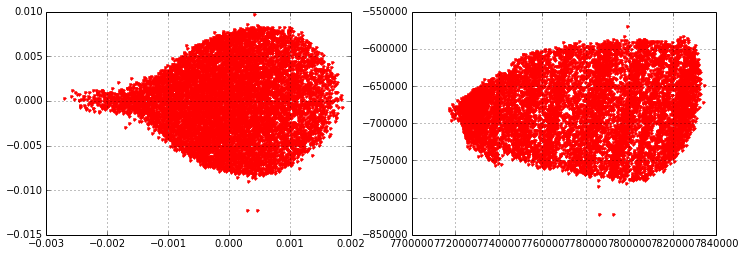

In [5]:
data=np.loadtxt('ast.0840.001')

#data[0,2]=0 #data[0,2]-8.3
data[1:,2]=data[1:,2]+data[0,2]
data[1:,5]=data[1:,5]+data[0,5]

xc=np.mean(data[:,0])
data[:,0]=data[:,0]-xc
zc=np.mean(data[:,2])
data[:,2]=data[:,2]-zc

fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(data[:,2],data[:,0],'r.')
axes[1].plot(data[:,5],data[:,3],'r.')
axes[0].grid()
axes[1].grid()

In [6]:
data=np.loadtxt('ast.0840.001')

#data[0,2]=0 #data[0,2]-8.3
data[1:,2]=data[1:,2]+data[0,2]  # z
data[1:,5]=data[1:,5]+data[0,5]  # pz 

xc=np.mean(data[:,0])
data[:,0]=data[:,0]-xc
zc=np.mean(data[:,2])
data[:,2]=data[:,2]-zc

alp=-5.0

for i in np.arange(len(data)):
    r=[data[i,2],data[i,0]]
    r1=transform2D(r,alp)
    p=[data[i,5],data[i,3]]
    p1=transform2D(p,alp)
    data[i,2]=r1[0]
    data[i,0]=r1[1]
    data[i,5]=p1[0]
    data[i,3]=p1[1]

data[1:,2]=data[1:,2]-data[0,2]
data[1:,5]=data[1:,5]-data[0,5]
np.savetxt('ast.0840.002',data,fmt='%12.4E')

NameError: name 'transform2D' is not defined

In [ ]:
data[0,2]=0 #data[0,2]-8.3
data[1:,2]=data[1:,2]+data[0,2]
data[1:,5]=data[1:,5]+data[0,5]

fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(data[:,2],data[:,0],'r.')
axes[1].plot(data[:,5],data[:,3],'r.')
axes[0].grid()
axes[1].grid()

In [ ]:
dipole=Dipole()
dipole.pos=8.2278+0.05
dipole.set_d24(48e-3,56e-3,91.7e-3,5./180.*np.pi)
dipole.radius=0.0
dipole.strength=0.03245
dipole.gap=0.045

dipole.output()

In [4]:
Lquad,Rquad=0.09,2.15
Q01,Q02=0.1,-0.1
D01,D02,D03=5.6635-4.8-Lquad/2.,0.25-Lquad,6.05-5.6635-Lquad/2-0.25+(58.9+5.5)/1000.
#print D01,D02,D03
B1=0
beta=17.355
Q1,Q2=0.5,-0.5
D1,D2,D3=(59+151)/1000.-Lquad/2.,(401-151)/1000.-Lquad,1.4254/2-0.401-Lquad/2.

## Astra modules

In [31]:
def transform2D(r,alpha,delta=[0,0]):
    'rotated about z-axis. alpha is the angle from x-y to x1-y1.'
    #alpha=alpha*np.pi/180.
    cc,ss=np.cos(alpha),np.sin(alpha)
    [x,y]=r
    dx,dy=delta[0],delta[1]
    x1,y1=x*cc+y*ss+dx,-x*ss+y*cc+dy
    return [x1,y1]

class Newrun:
    def __init__(self,head='',dis='',auto='false',track='true',check='false',run=1):
        self.Run=1
        self.Head=''
        self.Distribution=''
        self.Track_all='true'
        self.Auto_phase='true'
        self.check_ref_particle='false'
        self.offset=np.zeros(3)
        self.Z_min=-0.01
        self.H_max=0.005
        self.H_min=0
    def set_newrun(self,head='',dis='',auto='false',track='true',check='false',run=1):
        self.Head=head
        self.Distribution=dis
        self.Auto_phase=auto
        self.Track_all=track
        self.check_ref_particle=check
        self.Run=run
    def set_offset(self,offset=[0,0,0]):
        self.offset=offset
    def set_timestep(self,H_max=0.001,H_min=0,zmin=0):
        self.Z_min=zmin
        self.H_min=H_min
        self.H_max=H_max
    def output(self):
        oo='&NEWRUN \n Head=\''+self.Head+'\'\n'+\
        str.format(' RUN=%d\n' % (self.Run))+\
        str.format(' Distribution=\'%s\'\n' % (self.Distribution))+\
        str.format(' Xoff=%.6f\n' % (self.offset[0]))+\
        str.format(' Yoff=%.6f\n' % (self.offset[1]))+\
        str.format(' Zoff=%.6f\n' % (self.offset[2]))+\
        str.format(' TRACK_ALL=%s\n' % (self.Track_all))+\
        str.format(' AUTO_PHASE=%s\n' % (self.Auto_phase))+\
        str.format(' check_ref_part=%s\n' % (self.check_ref_particle))+\
        str.format(' H_max=%.6f\n' % (self.H_max))+\
        str.format(' H_min=%.6f\n' % (self.H_min))+\
        str.format(' Z_min=%.6f\n' % (self.Z_min))+\
        str.format(' Lprompt=false\n')
        oo=oo+'&\n'
        return oo

class Charge:
    def __init__(self):
        self.Lspch='true'
        self.Lspch3d='false'
        self.Lmirror='true'
        self.Nrad=20
        self.Nlong_in=50
        self.N_min=10
        self.Max_scale=0.05
        self.Max_count=20
    def set_charge(self,lsp='true',lm='true',lsp3d='false'):
        self.Lspch=lsp
        self.Lmirror=lm
        self.Lspch3d=lsp3d
    def set_grid(self,nrad=50,nlong=100):
        self.Nrad=nrad
        self.Nlong_in=nlong
    def set_scale(self,scale,count):
        self.Max_scale=scale
        self.Max_count=count
    def Set_Nmin(self,nmin):
        self.N_min=nmin

    def output(self):
        oo='&CHARGE \n'+\
        str.format(' LSPCH=%s\n' % (self.Lspch))+\
        str.format(' LSPCH3D=%s\n' % (self.Lspch3d))+\
        str.format(' Lmirror=%s\n' % (self.Lmirror))+\
        str.format(' Nrad=%.0f\n' % (self.Nrad))+\
        str.format(' Nlong_in=%.0f\n' % (self.Nlong_in))+\
        str.format(' N_min=%.0f\n' % (self.N_min))+\
        str.format(' Max_scale=%.6f\n' % (self.Max_scale))+\
        str.format(' Max_count=%.0f\n' % (self.Max_count))
        oo=oo+'&\n'
        return oo

class Dipole:
    def __init__(self,num=1,ldipole='true',smooth=3):
        self.Ld='true'
        self.num=num
        self.d_type=np.empty(num,dtype='S16')
        self.pos=np.zeros(num)
        self.gap=np.zeros(num)
        self.strength=np.zeros(num)
        self.radius=np.zeros(num)
        self.d24=np.zeros([num,2,4])
        self.xoff=np.zeros(num)
        self.yoff=np.zeros(num)
        self.xrot=np.zeros(num)
        self.yrot=np.zeros(num)
        self.zrot=np.zeros(num)
        self.smooth=np.ones(num)*smooth
    
    def set_dipole(self,seq=0,d_type='horizontal',pos=0,gap=0.05,strength=0,radius=0):
        self.d_type[seq]=d_type
        self.pos[seq]=pos
        self.gap[seq]=gap
        self.strength[seq]=strength
        self.radius[seq]=radius
        
    def set_d24(self,seq=0,a=0,b=0,c=0,alp=0,beta=0,delta=[0,0]):
        gam=alp/2.-beta
        rot=alp/2.
        r=[0,0]
        r=-c/2.*np.sin(gam), c/2.*np.cos(gam)
        self.d24[seq,1,0],self.d24[seq,0,0]=transform2D(r,rot,delta)
        r= c/2.*np.sin(gam),-c/2.*np.cos(gam)
        self.d24[seq,1,1],self.d24[seq,0,1]=transform2D(r,rot,delta)
        r= c/2.*np.sin(gam)+(a+b)/2., c/2.*np.cos(gam)
        self.d24[seq,1,2],self.d24[seq,0,2]=transform2D(r,rot,delta)
        r=-c/2.*np.sin(gam)+(a+b)/2.,-c/2.*np.cos(gam)
        self.d24[seq,1,3],self.d24[seq,0,3]=transform2D(r,rot,delta)
        
        self.d24[seq,1,:]=self.pos[seq]+self.d24[seq,1,:]
        #self.radius[seq]=-np.sqrt(((self.d24[seq,0,3]+self.d24[seq,0,2])/2.-(self.d24[seq,0,1]+self.d24[seq,0,0])/2.)**2+\
        #                     ((self.d24[seq,1,3]+self.d24[seq,1,2])/2.-(self.d24[seq,1,1]+self.d24[seq,1,0])/2.)**2)/2./np.sin(alp/2.)
    
    def set_d24_1(self,seq=0,a=0,b=0,c=0,alp=0,gam=0,delta=[0,0]):
        rot=alp/2.
        r=[0,0]
        r=-c/2.*np.sin(gam), c/2.*np.cos(gam)
        self.d24[seq,1,0],self.d24[seq,0,0]=transform2D(r,rot,delta)
        r= c/2.*np.sin(gam),-c/2.*np.cos(gam)
        self.d24[seq,1,1],self.d24[seq,0,1]=transform2D(r,rot,delta)
        r= c/2.*np.sin(gam)+(a+b)/2., c/2.*np.cos(gam)
        self.d24[seq,1,2],self.d24[seq,0,2]=transform2D(r,rot,delta)
        r=-c/2.*np.sin(gam)+(a+b)/2.,-c/2.*np.cos(gam)
        self.d24[seq,1,3],self.d24[seq,0,3]=transform2D(r,rot,delta)
        
        self.d24[seq,1,:]=self.pos[seq]+self.d24[seq,1,:]
    
    def set_d24_2(self,seq=0,a=0,b=0,h=0,alp=0,delta=[0,0]):
        ''' 
            以偏转轨迹的中心为原点，给出偏转轨迹外的磁极面长度a，偏转轨迹内的磁极面长度b，
            以及沿半径方向的高度h，alp为偏转方向，delta为中心的位置（2016.5）
        '''
        rot=alp/2.
        r=[0,0]
        r=-a/2., h/2. # z,x
        self.d24[seq,1,0],self.d24[seq,0,0]=transform2D(r,rot,delta)
        r=-b/2.,-h/2.
        self.d24[seq,1,1],self.d24[seq,0,1]=transform2D(r,rot,delta)
        r= a/2., h/2.
        self.d24[seq,1,2],self.d24[seq,0,2]=transform2D(r,rot,delta)
        r= b/2.,-h/2.
        self.d24[seq,1,3],self.d24[seq,0,3]=transform2D(r,rot,delta)
        
        self.d24[seq,1,:]=self.pos[seq]+self.d24[seq,1,:]
    
    def set_offset(self,seq=0,xoff=0,yoff=0):
        self.xoff[seq]=xoff
        self.yoff[seq]=yoff
    def set_rotation(self,seq=0,xrot=0,yrot=0,zrot=0):
        self.xrot[seq]=xrot
        self.yrot[seq]=yrot
        self.zrot[seq]=zrot
        
    def output(self,seq=1):
        oo='&DIPOLE \n LDipole='+self.Ld+'\n'
        for i in np.arange(self.num):
            seq=i
            oo=oo+str.format(' D_Type(%d)=\'%s\'\n' % (seq+1,self.d_type[seq]))+\
            str.format(' D1(%d)=(%.6f,%.6f)\n' % (seq+1,self.d24[seq,0,0],self.d24[seq,1,0]))+\
            str.format(' D2(%d)=(%.6f,%.6f)\n' % (seq+1,self.d24[seq,0,1],self.d24[seq,1,1]))+\
            str.format(' D3(%d)=(%.6f,%.6f)\n' % (seq+1,self.d24[seq,0,2],self.d24[seq,1,2]))+\
            str.format(' D4(%d)=(%.6f,%.6f)\n' % (seq+1,self.d24[seq,0,3],self.d24[seq,1,3]))+\
            str.format(' D_Gap(1,%d)=%.6f\n' % (seq+1,self.gap[seq]))+\
            str.format(' D_Gap(2,%d)=%.6f\n' % (seq+1,self.gap[seq]))+\
            str.format(' D_strength(%d)=%.6f\n' % (seq+1,self.strength[seq]))+\
            str.format(' D_xoff(%d)=%.6f\n' % (seq+1,self.xoff[seq]))+\
            str.format(' D_yoff(%d)=%.6f\n' % (seq+1,self.yoff[seq]))+\
            str.format(' D_xrot(%d)=%.6f\n' % (seq+1,self.xrot[seq]))+\
            str.format(' D_yrot(%d)=%.6f\n' % (seq+1,self.yrot[seq]))+\
            str.format(' D_zrot(%d)=%.6f\n' % (seq+1,self.zrot[seq]))+\
            str.format(' D_radius(%d)=%.6f\n' % (seq+1,self.radius[seq]))
        oo=oo+'&\n'
        return oo

class Quadrupole:
    def __init__(self,num=1,lquad='true',smooth=3):
        self.Lquad=lquad
        self.num=num
        self.pos=np.zeros(num)
        self.length=np.zeros(num)
        self.bore=np.zeros(num)
        self.grad=np.zeros(num)
        self.xoff=np.zeros(num)
        self.yoff=np.zeros(num)
        self.xrot=np.zeros(num)
        self.yrot=np.zeros(num)
        self.zrot=np.zeros(num)
        self.smooth=np.ones(num)*smooth
    def set_quadrupole(self,seq=0,pos=0,length=0,bore=0,grad=0):
        self.pos[seq]=pos
        self.length[seq]=length
        self.bore[seq]=bore
        self.grad[seq]=grad
    def set_offset(self,seq=0,xoff=0,yoff=0):
        self.xoff[seq]=xoff
        self.yoff[seq]=yoff
    def set_rotation(self,seq=0,xrot=0,yrot=0,zrot=0):
        self.xrot[seq]=xrot
        self.yrot[seq]=yrot
        self.zrot[seq]=zrot
    def output(self): 
        oo='&QUADRUPOLE \n Lquad='+self.Lquad+'\n'
        for i in np.arange(self.num):
            seq=i
            oo=oo+str.format(' Q_pos(%d)=%.6f\n' % (seq+1,self.pos[seq]))+\
            str.format(' Q_length(%d)=%.6f\n' % (seq+1,self.length[seq]))+\
            str.format(' Q_bore(%d)=%.6f\n' % (seq+1,self.bore[seq]))+\
            str.format(' Q_grad(%d)=%.6f\n' % (seq+1,self.grad[seq]))+\
            str.format(' Q_xoff(%d)=%.6f\n' % (seq+1,self.xoff[seq]))+\
            str.format(' Q_yoff(%d)=%.6f\n' % (seq+1,self.yoff[seq]))+\
            str.format(' Q_xrot(%d)=%.6f\n' % (seq+1,self.xrot[seq]))+\
            str.format(' Q_yrot(%d)=%.6f\n' % (seq+1,self.yrot[seq]))+\
            str.format(' Q_zrot(%d)=%.6f\n' % (seq+1,self.zrot[seq]))+\
            str.format(' Q_smooth(%d)=%d\n' % (seq+1,self.smooth[seq]))
        oo=oo+'&\n'
        return oo

class Output:
    def __init__(self,zstart=0,zstop=1,zemit=10,zphase=2,ns=0):
        self.Zstart=zstart
        self.Zstop=zstop
        self.Zemit=zemit
        self.Zphase=zphase
        self.NS=ns
        self.Screen=np.zeros(1)
        self.control={'Lmagnetized':'false','RefS':'true','EmitS':'true','PhaseS':'true',\
                      'TrackS':'true','LandFS':'true','Local_emit':'true','Lproject_emit':'false',\
                      'Tr_emitS':'false'}
    def set_output(self,zstart=0,zstop=1,zemit=10,zphase=2,ns=0):
        self.Zstart=zstart
        self.Zstop=zstop
        self.Zemit=zemit
        self.Zphase=zphase
        self.NS=ns
    def set_screen(self,a):
        self.Screen=a
    def output(self):
        oo='&OUTPUT \n'+\
        str.format(' ZSTART=%.6f\n' % (self.Zstart))+\
        str.format(' ZSTOP=%.6f\n' % (self.Zstop))+\
        str.format(' Zemit=%d\n' % (self.Zemit))+\
        str.format(' Zphase=%d\n' % (self.Zphase))
        if self.Screen[0]!=0:
            for i in np.arange(len(self.Screen)):
                oo=oo+str.format(' Screen(%d)=%.6f\n' % (i+1,self.Screen[i]))
        for k,v in self.control.iteritems():
            oo=oo+str.format(' %s=%s\n' %(k,v))
        oo=oo+'&\n'
        return oo

class Cavity:
    def __init__(self,num=1,LE='true',smooth=3):
        self.num=num
        self.LEfield=LE
        self.C_pos=np.zeros(num) # m
        self.MaxE=np.zeros(num)  # MV/m
        self.Nue=np.zeros(num)   # GHz
        self.Phi=np.zeros(num)   # deg
        self.File_Efield=np.empty(num, dtype=object)
        self.C_smooth=3
    def set_cavity(self,i,pos,Ea,freq,phi,fname):
        self.C_pos[i]=pos
        self.MaxE[i]=Ea
        self.Nue[i]=freq
        self.Phi[i]=phi
        self.File_Efield[i]=fname
    def output(self):
        oo='&CAVITY \n'+' LEField='+self.LEfield+'\n'
        for i in np.arange(self.num):
            seq=i
            oo=oo+str.format(' C_pos(%d)=%.6f\n' % (seq+1,self.C_pos[seq]))+\
            str.format(' MaxE(%d)=%.6f\n' % (seq+1,self.MaxE[seq]))+\
            str.format(' Nue(%d)=%.6f\n' % (seq+1,self.Nue[seq]))+\
            str.format(' Phi(%d)=%.6f\n' % (seq+1,self.Phi[seq]))+\
            str.format(' File_Efield(%d)=\'%s\'\n' % (seq+1,self.File_Efield[i]))+\
            str.format(' C_smooth(%d)=%d, C_higher_order(%d)=T\n' % (seq+1,self.C_smooth,seq+1))
        oo=oo+'&\n'
        return oo

class Solenoid:
    def __init__(self,num,LB='true'):
        self.num=num
        self.LBfield=LB
        self.S_pos=np.zeros(num) # m
        self.MaxB=np.zeros(num)  # T
        self.File_Bfield=np.empty(num, dtype=object)
        self.C_smooth=3
    def set_solenoid(self,i,pos,freq,fname):
        self.S_pos[i]=pos
        self.MaxB[i]=freq
        self.File_Bfield[i]=fname
    def output(self):
        oo='&SOLENOID \n'+' LBField='+self.LBfield+'\n'
        for i in np.arange(self.num):
            seq=i
            oo=oo+str.format(' S_pos(%d)=%.6f\n' % (seq+1,self.S_pos[seq]))+\
            str.format(' MaxB(%d)=%.6f\n' % (seq+1,self.MaxB[seq]))+\
            str.format(' File_Bfield(%d)=\'%s\'\n' % (seq+1,self.File_Bfield[i]))
            str.format(' S_smooth(%d)=%d, S_higher_order(%d)=T\n' % (seq+1,self.S_smooth,seq+1))
        oo=oo+'&\n'
        return oo

In [5]:
def xy_start_point(a,b,h,h1,R,alpha):
    d1=b-1.0*h1/h*(b-a)
    #print d1
    beta=alpha/2.-np.arcsin(d1/R/2.)
    d2=2.*R*np.sin(beta/2.)
    x=d2*np.cos(beta/2.)
    y=-d2*np.sin(beta/2.)
    #print beta*180/np.pi,d2
    return [x,y]
delta=np.array(xy_start_point(102e-3,120e-3,100e-3,46e-3,200e-3,45./180*np.pi))
a,b,h,h1,R=102e-3,120e-3,100e-3,46e-3,200e-3
a1=b-1.0*h1*2/h*(b-a)
b1=b
c1=np.sqrt(((b1-a1)/2.)**2+(h1*2.)**2)
alp1=np.arcsin((a1+b1)/2./R/2.)*2.
gam1=np.arcsin((b1-a1)/2./c1)

print delta
print a1,b1,c1,alp1/np.pi*180,gam1/np.pi*180

[ 0.02188291 -0.00120076]
0.10344 0.12 0.0923718485254 32.4368619473 5.14276455788


# Achromatic

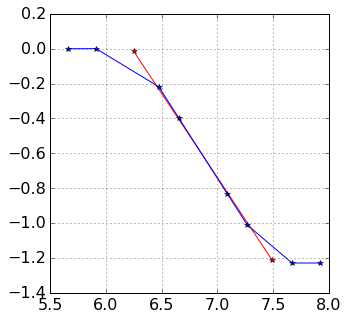

set arrow from 5.663000,graph 0 to 5.663000,graph 1 lc 1
set arrow from 5.913000,graph 0 to 5.913000,graph 1 lc 1
set arrow from 6.474404,graph 0 to 6.474404,graph 1 lc 1
set arrow from 6.651181,graph 0 to 6.651181,graph 1 lc 1
set arrow from 7.089587,graph 0 to 7.089587,graph 1 lc 1
set arrow from 7.266364,graph 0 to 7.266364,graph 1 lc 1
set arrow from 6.249537,graph 0 to 6.249537,graph 1 lc 2
set arrow from 7.491231,graph 0 to 7.491231,graph 1 lc 2


In [4]:
##
Lquad,Rquad=0.09,2.15e-2

pos,R,alpha=4.931,0.2,45./180*np.pi
q_coor=[]
b_coor=[]

L=0.732
z,x=pos+L,0
q_coor.append([z,x])
L=0.732+0.25
z,x=pos+L,0
q_coor.append([z,x])

## begining of bending
L=1.242
z,x=pos+L+R*np.sin(alpha/2.),R*(np.cos(alpha/2)-1)
b_coor.append([z,x])

ZB1,XB1=pos+L+R*np.sin(alpha),R*(np.cos(alpha)-1)
#coor=[]
L=0.2215
z,x=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)
q_coor.append([z,x])
L=0.2215+0.25
z,x=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)
q_coor.append([z,x])
L=1.567-0.2215-0.25
z,x=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)
q_coor.append([z,x])
L=1.567-0.2215
z,x=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)
q_coor.append([z,x])

L=1.567
z,x=ZB1+L*np.cos(alpha)+R*(np.sin(alpha)-np.sin(alpha/2.)),XB1-L*np.sin(alpha)-R*(np.cos(alpha/2.)-np.cos(alpha))
b_coor.append([z,x])
## end of bending

## another two quads
z,x=ZB1+L*np.cos(alpha)+R*np.sin(alpha)+0.1,XB1-L*np.sin(alpha)-R*(1-np.cos(alpha))
q_coor.append([z,x])
z,x=z+0.25,x
q_coor.append([z,x])

q_coor=np.array(q_coor)
b_coor=np.array(b_coor)

plt.figure(figsize=(5,5))
plt.plot(b_coor[:,0],b_coor[:,1],'r-*')
plt.plot(q_coor[:,0],q_coor[:,1],'b-*')
###
data=np.loadtxt('ast.ref.001')
plt.plot(data[:,0],data[:,5]/1000,'g')
###
plt.grid()
plt.savefig('traj.eps')
plt.show()
for i in np.arange(6):
    print str.format('set arrow from %.6f,graph 0 to %.6f,graph 1 lc 1' % (q_coor[i,0],q_coor[i,0]))
for i in np.arange(2):
    print str.format('set arrow from %.6f,graph 0 to %.6f,graph 1 lc 2' % (b_coor[i,0],b_coor[i,0]))

In [51]:
workdir='E:\\Lixiangkun\\Work\\THz-FEL-2\\320kV-gauss\\___\\Transport'
os.chdir(workdir)

grad=-np.array([0.1455,-0.0630,0.3721,-0.2396,-0.2396,0.3721,0.,-0.])*0.1/2.15e-2
#grad=-np.array([0.1139,0.0421,0.4345,-0.3921,-0.3921,0.4345,0.,-0.])*0.1/2.15e-2
#grad=-np.array([0.1492,-0.1002,0.4477,-0.4926,-0.4926,0.4477,0.4040,-0.1717])*0.1/2.15e-2
grad=-np.array([0.0216,0.2354,0.0527,0.3002,0.3002,0.0527,0.,-0.])*0.1/2.15e-2
grad=-np.array([-0.0612, 0.2820, 0.0428, 0.3, 0.3, 0.0428,0.,-0.])*0.1/2.15e-2
grad=-np.array([0.0120,0.0722,0.1254,0.2764,0.2764,0.1254,0.,-0.])*0.1/2.15e-2
grad=-np.array([ 0.2598,-0.3185, 0.4255,-0.3632,-0.3632, 0.4255,0.,-0.])*0.1/2.15e-2
grad=-np.array([ 0.0024, 0.2398, 0.3872,-0.1845,-0.1845, 0.3872,0.,-0.])*0.1/2.15e-2 # opt

grad=-np.array([-0.0164, 0.1901, 0.4173,-0.4129,-0.4129, 0.4173,0.,-0.])*0.1/2.15e-2 

strength=np.array([0.17108,-0.17108])

newrun=Newrun()
newrun.set_newrun(head='Achromatic section of CAEP FEL-THz facility',\
                  dis='./ast.0500.000')
charge=Charge()
charge.set_charge(lsp3d='true')

pos0=0
#a,b,c=102e-3,120e-3,100.4e-3
alpha,beta=45*np.pi/180.,17.355*np.pi/180.

#dipole=Dipole(2)
#for i in np.arange(2):
#    dipole.set_dipole(i,pos=b_coor[i,0],strength=strength[i],gap=0.045)
#    dipole.set_offset(i,xoff=b_coor[i,1])
#dipole.set_d24_1(0,b1,a1,c1,alpha,-gam1,delta)
#print delta
#delta1=transform2D(delta,alpha)
#print delta1
#dipole.set_d24_1(1,a1,b1,c1,alpha,gam1,delta1)

a1,b1,c1=102e-3,120e-3,100e-3
dipole=Dipole(2)
for i in np.arange(2):
    dipole.set_dipole(i,pos=b_coor[i,0],strength=strength[i],gap=0.045)
    dipole.set_offset(i,xoff=b_coor[i,1])
dipole.set_d24_2(0,a1,b1,c1,alpha)
dipole.set_d24_2(1,b1,a1,c1,alpha)

quadrupole=Quadrupole(6)
for i in np.arange(6):
    quadrupole.set_quadrupole(i,pos=q_coor[i,0],bore=Rquad,grad=grad[i],length=0.09)
    quadrupole.set_offset(i,xoff=q_coor[i,1])
for i in np.arange(2,6):
    quadrupole.set_rotation(i,xrot=-alpha)

output=Output()
output.set_output(zstart=4,zstop=8,zemit=400,zphase=2)

ss=newrun.output()+charge.output()+dipole.output()+quadrupole.output()+output.output()
#charge.output()+
ff = open('ast.in', 'w')
ff.write(ss)
ff.close()

In [38]:
xx=np.array([1.65,1.7,1.75])
yy=np.array([46.5744,45.2873,43.9550])
ff=interp1d(yy,xx,bounds_error=False)
print ff(45)

1.71078210613


# Chicane

In [15]:
workdir='F:\\Workshop\\THz-FEL\\8ps\\Part1.2\\1'
os.chdir(workdir)

bfield=0.329e-1
strength=np.array([bfield,-bfield,-bfield,bfield])
b_coor=np.array([[5.0,5.7,6.1,6.8],[0,-0.21,-0.21,0]]).T

newrun=Newrun()
newrun.set_newrun(head='Magnetic compression of CAEP FEL-THz facility',\
                  dis='../field-maps/ast.0480.001')

pos0=0
#a,b,c=102e-3,120e-3,100.4e-3
alpha,beta=22.5*np.pi/180.,0*np.pi/180.
#alpha=0
#delta=[1,1]
a1,b1,c1=0.2,0.2,0.2

dipole=Dipole(4)
for i in np.arange(4):
    dipole.set_dipole(i,pos=b_coor[i,0],strength=strength[i],gap=0.03)
    dipole.set_offset(i,xoff=b_coor[i,1])
    dipole.set_d24_1(i,b1,a1,c1,0,0)

output=Output()
output.set_output(zstart=0,zstop=8,zemit=400,zphase=2)

ss=newrun.output()+dipole.output()+output.output()

ff = open('ast.in', 'w')
ff.write(ss)
ff.close()

# Merger

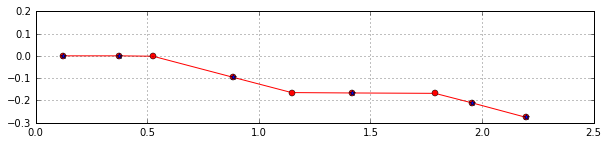

In [55]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Merger'
os.chdir(workdir)

Lquad,Rquad=0.09,2.15e-2
D01,D02,D03=0.08,0.25-Lquad,0.08
D1,D2=0.3,0.2
D11,D12,D13=0.1,0.25-Lquad,0.1

R=0.2
alpha,beta=15.0*np.pi/180.,7.5*np.pi/180.
L=R*np.sin(alpha/2)*2

coor=[]
p0=.0 # 5.0
qz01,qx01=p0+D01+Lquad/2,0
qz02,qx02=qz01+Lquad+D02,0
qz1,qx1=p0+0.5+R*np.sin(alpha)+(D1+Lquad/2)*np.cos(alpha),-R*(1-np.cos(alpha))-(D1+Lquad/2)*np.sin(alpha)
qz2,qx2=p0+0.5+2*R*np.sin(alpha)+(D1+Lquad+D2)*np.cos(alpha)+D2+Lquad/2.,-2*R*(1-np.cos(alpha))-(D1+Lquad+D2)*np.sin(alpha)

bz1,bx1=p0+0.5+R*np.sin(beta),-R*(1-np.cos(beta))
bz2,bx2=p0+0.5+2*R*np.sin(alpha)+(D1+Lquad+D2)*np.cos(alpha)-R*np.sin(beta),-2*R*(1-np.cos(alpha))-(D1+Lquad+D2)*np.sin(alpha)+R*(1-np.cos(beta))
bz3,bx3=  p0+0.5+2*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+R*np.sin(beta),qx2-R*(1-np.cos(beta))

qz11,qx11=p0+0.5+3*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+(D11+Lquad/2.)*np.cos(alpha),\
          qx2-R*(1-np.cos(alpha))-(D11+Lquad/2.)*np.sin(alpha)
qz12,qx12=p0+0.5+3*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+(D11+Lquad+D12+Lquad/2.)*np.cos(alpha),\
          qx2-R*(1-np.cos(alpha))-(D11+Lquad+D12+Lquad/2.)*np.sin(alpha)

coor=np.array([[qz01,qz02,bz1,qz1,bz2,qz2,bz3,qz11,qz12],[qx01,qx02,bx1,qx1,bx2,qx2,bx3,qx11,qx12]]).T
plt.figure(figsize=(10,2))
plt.plot(coor[:,0],coor[:,1],'ro-')
plt.plot(q_coor[:,0],q_coor[:,1],'b*')
plt.axis([0,2.5,-0.3,0.2])
plt.grid()
plt.show()

q_coor=np.array([[qz01,qz02,qz1,qz2,qz11,qz12],[qx01,qx02,qx1,qx2,qx11,qx12]]).T
b_coor=np.array([[bz1,bz2,bz3],[bx1,bx2,bx3]]).T

bfield=0.37122e-1 # T
strength=np.array([bfield,-bfield,bfield])
grad=np.array([0.15535,-0.14469,0.14417,0.14417,0.28584,-0.13406]).T/10.

newrun=Newrun()
newrun.set_newrun(head='Merger of CAEP ERL-THz',dis='./ast.0480.001')
pos0=0
#delta=[1,1]
a1,b1,c1=L,L,0.1

dipole=Dipole(3)
for i in np.arange(3):
    dipole.set_dipole(i,pos=b_coor[i,0],strength=strength[i],gap=0.045)
    dipole.set_offset(i,xoff=b_coor[i,1])
    dipole.set_d24_2(i,a1,b1,c1,alpha)

output=Output()
output.set_output(zstart=0,zstop=7,zemit=350,zphase=2)

quadrupole=Quadrupole(6)
for i in np.arange(6):
    quadrupole.set_quadrupole(i,pos=q_coor[i,0],bore=Rquad,grad=grad[i],length=0.09)
    quadrupole.set_offset(i,xoff=q_coor[i,1])
for i in np.arange(2,6):
    quadrupole.set_rotation(i,xrot=-alpha)
    
ss=newrun.output()+dipole.output()+output.output()

ff = open('ast.in', 'w')
ff.write(ss)
ff.close()

## Pre-merger

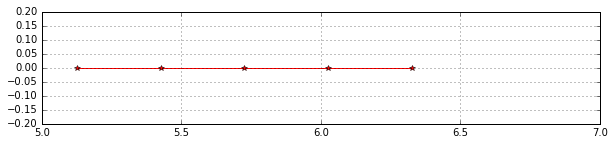

In [107]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Pre-merger'
os.chdir(workdir)

Lquad,Rquad=0.09,2.15e-2

Dri=0.3
D=np.array([0.08,Dri-Lquad,Dri-Lquad+0.,Dri-Lquad+0.,Dri-Lquad,Dri-Lquad,0.18]).T

q_coor=np.zeros((5,2))

q_coor[0,0]=D[0]+Lquad/2.
for i in np.arange(1,5):
    q_coor[i,0]=q_coor[i-1,0]+D[i]+Lquad

q_coor[:,0]=q_coor[:,0]+5

plt.figure(figsize=(10,2))
plt.plot(q_coor[:,0],q_coor[:,1],'r-*')
plt.axis([5,7,-0.2,0.2])
plt.grid()
plt.show()

grad=-np.array([ 0.1258,-0.2271, 1.4442,-0.2009, 0.1088]).T/10./Rquad # 5月13日：水平方向发射度不变
#grad=-np.array([ 0.1545,-0.1702, 0.0434, 0.1660,-0.1982]).T/10./Rquad
#grad=-np.array([ 0.088,-0.139, 0.147,-0.095, 0.163]).T/10./Rquad
grad=-np.array([ 0.0571,-0.1189, 0.1752,-0.1431, 0.2248]).T/10./Rquad # 5月17日#1
grad=-np.array([ 0.0453,-0.1378, 0.2580,-0.2342, 0.3613]).T/10./Rquad # 5月17日#2
grad=-np.array([ 0.0480,-0.1076, 0.1717,-0.1876, 0.2991]).T/10./Rquad # 5月17日#3
grad=-np.array([ 0.0336,-0.0920, 0.1569,-0.1347, 0.2220]).T/10./Rquad # 5月17日#4
grad=-np.array([ 0.1120,-0.2067, 1.4019,-0.2179, 0.0990]).T/10./Rquad # 5月17日#5
grad=-np.array([ 0.1069,-0.2061, 0.0197,-0.2061, 0.1069]).T/10./Rquad # 5月17日#6

grad=-np.array([ 0.1256,-0.2706, 0.0000,-0.2719, 0.1146]).T/10./Rquad # 5月17日


newrun=Newrun()
newrun.set_newrun(head='Merger of CAEP ERL-THz',dis='./ast.0500.000')
charge=Charge()
charge.set_charge(lsp3d='true')
pos0=0

output=Output()
output.set_output(zstart=5,zstop=7,zemit=100,zphase=5)

nq=len(q_coor[:,0])
quadrupole=Quadrupole(nq)
for i in np.arange(nq):
    quadrupole.set_quadrupole(i,pos=q_coor[i,0],bore=Rquad,grad=grad[i],length=0.09)
    quadrupole.set_offset(i,xoff=q_coor[i,1])
    
ss=newrun.output()+charge.output()+quadrupole.output()+output.output()

ff=open('ast.in', 'w')
ff.write(ss)
ff.close()

# Merger1

In [4]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Merger'
os.chdir(workdir)

In [32]:
data=np.loadtxt('ast.0500.000')

#print astra_post(data)
#data[0,2]=0 #data[0,2]-8.3
data[1:,2]=data[1:,2]+data[0,2]  # z
data[1:,5]=data[1:,5]+data[0,5]  # pz 

xc=np.mean(data[:,0])
data[:,0]=data[:,0]-xc
zc=np.mean(data[:,2])
data[:,2]=data[:,2]-zc
#print np.std(data[:,2])**2+np.std(data[:,0])**2

alp=15.0/180.*np.pi

for i in np.arange(len(data)):
    r=[data[i,2],data[i,0]]
    r1=transform2D(r,alp)
    p=[data[i,5],data[i,3]]
    p1=transform2D(p,alp)
    data[i,2]=r1[0]
    data[i,0]=r1[1]
    data[i,5]=p1[0]
    data[i,3]=p1[1]
#print np.std(data[:,2])**2+np.std(data[:,0])**2

data[1:,2]=data[1:,2]-data[0,2]
data[0,2]=0
data[1:,5]=data[1:,5]-data[0,5]
#print astra_post(data)
np.savetxt('ast.0500.rot',data,fmt='%12.4E')

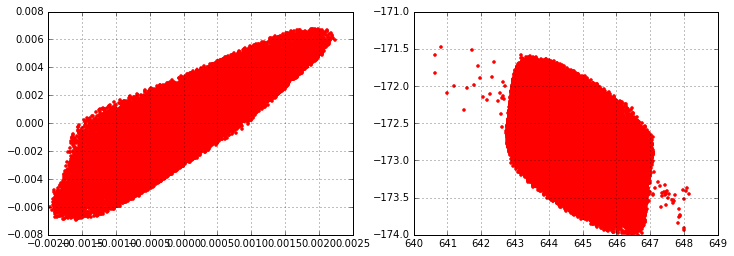

In [90]:
#data[0,2]=0 #data[0,2]-8.3
data[1:,2]=data[1:,2]+data[0,2]
data[1:,5]=data[1:,5]+data[0,5]

fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(data[:,2],data[:,0],'r.')
axes[1].plot(data[:,5]/1e4,data[:,3]/1e4,'r.')
axes[0].grid()
axes[1].grid()

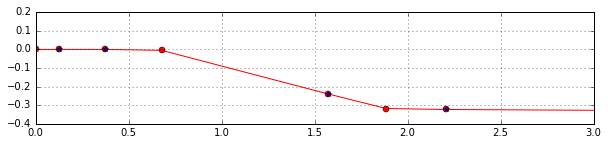

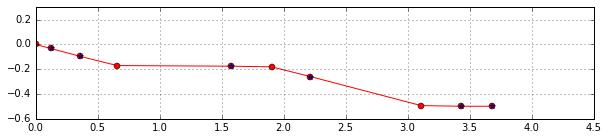

In [95]:
Lquad,Rquad=0.09,2.15e-2
D01,D02,D03=0.08,0.25-Lquad,0.18
D1,D2=0.8,0.2
D11,D12,D13=0.2,0.25-Lquad,0.1

R=600e-3
alpha,beta=15.0*np.pi/180.,7.5*np.pi/180.

coor=[]
p0,dd=.0,0.6 # 5.0
qz01,qx01=p0+D01+Lquad/2,0
qz02,qx02=qz01+Lquad+D02,0
qz1,qx1=p0+dd+R*np.sin(alpha)+(D1+Lquad/2)*np.cos(alpha),-R*(1-np.cos(alpha))-(D1+Lquad/2)*np.sin(alpha)
qz2,qx2=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2)*np.cos(alpha)+D2+Lquad/2.,-2*R*(1-np.cos(alpha))-(D1+Lquad+D2)*np.sin(alpha)

bz1,bx1=p0+dd+R*np.sin(beta),-R*(1-np.cos(beta))
bz2,bx2=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2)*np.cos(alpha)-R*np.sin(beta),-2*R*(1-np.cos(alpha))-(D1+Lquad+D2)*np.sin(alpha)+R*(1-np.cos(beta))
bz3,bx3=  p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+R*np.sin(beta),qx2-R*(1-np.cos(beta))

qz11,qx11=p0+dd+3*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+(D11+Lquad/2.)*np.cos(alpha),\
          qx2-R*(1-np.cos(alpha))-(D11+Lquad/2.)*np.sin(alpha)
qz12,qx12=p0+dd+3*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+(D11+Lquad+D12+Lquad/2.)*np.cos(alpha),\
          qx2-R*(1-np.cos(alpha))-(D11+Lquad+D12+Lquad/2.)*np.sin(alpha)

coor=np.array([[0,qz01,qz02,bz1,qz1,bz2,qz2,bz3,qz11,qz12],[0,qx01,qx02,bx1,qx1,bx2,qx2,bx3,qx11,qx12]]).T
q_coor=np.array([[qz01,qz02,qz1,qz2,qz11,qz12],[qx01,qx02,qx1,qx2,qx11,qx12]]).T
b_coor=np.array([[bz1,bz2,bz3],[bx1,bx2,bx3]]).T

plt.figure(figsize=(10,2))
plt.plot(coor[:,0],coor[:,1],'ro-')
plt.plot(q_coor[:,0],q_coor[:,1],'b*')
plt.axis([0,3,-0.4,0.2])
plt.grid()
plt.show()

coor[:,1]=-coor[:,1]
b_coor[:,1]=-b_coor[:,1]
q_coor[:,1]=-q_coor[:,1]
for i in np.arange(len(coor[:,0])):
    r=transform2D(coor[i,:],alpha)
    coor[i,:]=r
for i in np.arange(len(b_coor[:,0])):
    r=transform2D(b_coor[i,:],alpha)
    b_coor[i,:]=r
for i in np.arange(len(q_coor[:,0])):
    r=transform2D(q_coor[i,:],alpha)
    q_coor[i,:]=r
coor[:,0]=coor[:,0]+0#4.8
b_coor[:,0]=b_coor[:,0]+0#4.8
q_coor[:,0]=q_coor[:,0]+0#4.8

plt.figure(figsize=(10,2))
plt.plot(coor[:,0],coor[:,1],'ro-')
plt.plot(q_coor[:,0],q_coor[:,1],'b*')
plt.axis([0,4.5,-0.6,0.3])
plt.grid()
plt.show()

bfield=0.3759  #T
strength=np.array([-bfield,bfield,-bfield]).T/10.
grad=-np.array([0.1598,-0.1515,0.1233,0.1233,0.2559,-0.1293]).T/10./Rquad
grad=-np.array([0.0410,-0.0840,0.0528,0.0528,0.4885,-0.3798]).T/10./Rquad
grad=-np.array([0.1473,-0.1506, 0.1587, 0.1587, 0.1893,-0.1223]).T/10./Rquad

grad=-np.array([ 0.0746,-0.0847, 0.0201, 0.0201, 0.0486, 0.0013]).T/10./Rquad
grad[2]=grad[3]=-0.03
newrun=Newrun()
newrun.set_newrun(head='Merger of CAEP ERL-THz',dis='./ast.0500.rot')
charge=Charge()
charge.set_charge(lsp3d='true')
pos0=0
#delta=[1,1]
a1,b1,c1=2*(R-75e-3)*np.sin(beta),2*(R+75e-3)*np.sin(beta),150e-3
ab=np.array([[a1,b1,a1],[b1,a1,b1]]).T

dipole=Dipole(3)
for i in np.arange(3):
    dipole.set_dipole(i,pos=b_coor[i,0],strength=strength[i],gap=0.045)
    dipole.set_offset(i,xoff=b_coor[i,1])
    dipole.set_d24_2(i,ab[i,0],ab[i,1],c1,alpha)

output=Output()
output.set_output(zstart=0,zstop=4.,zemit=200,zphase=2)

quadrupole=Quadrupole(6)
for i in np.arange(6):
    quadrupole.set_quadrupole(i,pos=q_coor[i,0],bore=Rquad,grad=grad[i],length=0.09)
    quadrupole.set_offset(i,xoff=q_coor[i,1])
for i in (0,1,3):
    quadrupole.set_rotation(i,xrot=-alpha)
    
ss=newrun.output()+charge.output()+dipole.output()+quadrupole.output()+output.output()

ff=open('ast.in', 'w')
ff.write(ss)
ff.close()

## Merger2

In [1]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Merger2'
os.chdir(workdir)

Lquad,Rquad=0.09,2.15e-2
D01,D02,D03=0.08,0.25-Lquad,0.18
D1,D2,D3=0.3,0.16,0.3
D11,D12,D13=0.2,0.25-Lquad,0.1

R=600e-3
alpha,beta=15.0*np.pi/180.,7.5*np.pi/180.

coor=[]
p0,dd=.0,0.6 # 5.0
qz01,qx01=p0+D01+Lquad/2,0
qz02,qx02=qz01+Lquad+D02,0

qz1,qx1=p0+dd+R*np.sin(alpha)+(D1+Lquad/2)*np.cos(alpha),-R*(1-np.cos(alpha))-(D1+Lquad/2)*np.sin(alpha)
qz2,qx2=qz1+(Lquad+D2)*np.cos(alpha),qx1-(Lquad+D2)*np.sin(alpha)
qz3,qx3=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2+Lquad+D3)*np.cos(alpha)+D3+Lquad/2.,\
        -2*R*(1-np.cos(alpha))-(D1+Lquad+D2+Lquad+D3)*np.sin(alpha)
qz4,qx4=qz3+D2+Lquad,qx3

bz1,bx1=p0+dd+R*np.sin(beta),-R*(1-np.cos(beta))
bz2,bx2=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2+Lquad+D3)*np.cos(alpha)-R*np.sin(beta),\
        -2*R*(1-np.cos(alpha))-(D1+Lquad+D2+Lquad+D3)*np.sin(alpha)+R*(1-np.cos(beta))
bz3,bx3=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2+Lquad+D3)*(1+np.cos(alpha))+R*np.sin(beta),qx3-R*(1-np.cos(beta))

qz11,qx11=p0+dd+3*R*np.sin(alpha)+(D1+Lquad+D2+Lquad+D3)*(1+np.cos(alpha))+(D11+Lquad/2.)*np.cos(alpha),\
          qx3-R*(1-np.cos(alpha))-(D11+Lquad/2.)*np.sin(alpha)
qz12,qx12=p0+dd+3*R*np.sin(alpha)+(D1+Lquad+D2+Lquad+D3)*(1+np.cos(alpha))+(D11+Lquad+D12+Lquad/2.)*np.cos(alpha),\
          qx3-R*(1-np.cos(alpha))-(D11+Lquad+D12+Lquad/2.)*np.sin(alpha)

coor=np.array([[0,qz01,qz02,bz1,qz1,qz2,bz2,qz3,qz4,bz3,qz11,qz12],[0,qx01,qx02,bx1,qx1,qx2,bx2,qx3,qx4,bx3,qx11,qx12]]).T
q_coor=np.array([[qz01,qz02,qz1,qz2,qz3,qz4,qz11,qz12],[qx01,qx02,qx1,qx2,qx3,qx4,qx11,qx12]]).T
b_coor=np.array([[bz1,bz2,bz3],[bx1,bx2,bx3]]).T

plt.figure(figsize=(10,2))
plt.plot(coor[:,0],coor[:,1],'ro-')
plt.plot(q_coor[:,0],q_coor[:,1],'b*')
plt.axis([0,4,-0.6,0.2])
plt.grid()
plt.show()

coor[:,1]=-coor[:,1]
b_coor[:,1]=-b_coor[:,1]
q_coor[:,1]=-q_coor[:,1]
for i in np.arange(len(coor[:,0])):
    r=transform2D(coor[i,:],alpha)
    coor[i,:]=r
for i in np.arange(len(b_coor[:,0])):
    r=transform2D(b_coor[i,:],alpha)
    b_coor[i,:]=r
for i in np.arange(len(q_coor[:,0])):
    r=transform2D(q_coor[i,:],alpha)
    q_coor[i,:]=r
coor[:,0]=coor[:,0]+0#4.8
b_coor[:,0]=b_coor[:,0]+0#4.8
q_coor[:,0]=q_coor[:,0]+0#4.8

plt.figure(figsize=(10,2))
plt.plot(coor[:,0],coor[:,1],'ro-')
plt.plot(q_coor[:,0],q_coor[:,1],'b*')
plt.axis([0,4,-0.6,0.2])
plt.grid()
plt.show()

bfield=0.3759  #T
strength=np.array([-bfield,bfield,-bfield]).T/10.
grad=-np.array([0.1598,-0.1515,0.1233,0.1233,0.2559,-0.1293]).T/10./Rquad
grad=-np.array([0.0410,-0.0840,0.0528,0.0528,0.4885,-0.3798]).T/10./Rquad
grad=-np.array([0.1473,-0.1506, 0.1587, 0.1587, 0.1893,-0.1223]).T/10./Rquad
grad=-np.array([0.1676,-0.1714, 0.2841, -0.5000, -0.5000, 0.2841, 0.3637,-0.1526]).T/10./Rquad
#grad=-np.array([0.2275,-0.1655, 0.2228,-0.2534,-0.2534, 0.2228,-0.2835, 0.2235]).T/10./Rquad
print grad

grad=-np.array([0,0, 0.1233,-0.2162,-0.2162, 0.1233,0, 0]).T/10./Rquad
#grad=np.zeros(8)

# 2016年6月7日
grad=-np.array([ 0.2013,-0.1964, 0.2469,-0.3172,-0.3172, 0.2469, 0.5155,-0.1740]).T/10./Rquad

newrun=Newrun()
newrun.set_newrun(head='Merger of CAEP ERL-THz',dis='./ast.0500.rot')
charge=Charge()
charge.set_charge(lsp3d='true')
pos0=0
#delta=[1,1]
a1,b1,c1=2*(R-75e-3)*np.sin(beta),2*(R+75e-3)*np.sin(beta),150e-3
ab=np.array([[a1,b1,a1],[b1,a1,b1]]).T

dipole=Dipole(3)
for i in np.arange(3):
    dipole.set_dipole(i,pos=b_coor[i,0],strength=strength[i],gap=0.045)
    dipole.set_offset(i,xoff=b_coor[i,1])
    dipole.set_d24_2(i,ab[i,0],ab[i,1],c1,alpha)

output=Output()
output.set_output(zstart=0,zstop=4,zemit=200,zphase=2)

quadrupole=Quadrupole(8)
for i in np.arange(8):
    quadrupole.set_quadrupole(i,pos=q_coor[i,0],bore=Rquad,grad=grad[i],length=0.09)
    quadrupole.set_offset(i,xoff=q_coor[i,1])
for i in (0,1,4,5):
    quadrupole.set_rotation(i,xrot=-alpha)
    
ss=newrun.output()+charge.output()+dipole.output()+quadrupole.output()+output.output()

ff=open('ast.in', 'w')
ff.write(ss)
ff.close()

NameError: name 'os' is not defined

## Main acc

In [50]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Main-acc'
os.chdir(workdir)

newrun=Newrun()
newrun.set_newrun(head='Main acc of CAEP ERL-THz',dis='./ast.0450.000')
newrun.set_offset([498.6,0,-4.5])

charge=Charge()
charge.set_charge(lsp3d='true')

output=Output()
output.set_output(zstart=0,zstop=4,zemit=200,zphase=2)
output.set_screen(np.array([2.5,3.5]))

cavity=Cavity(2)
cavity.set_cavity(0,pos=0,Ea=24,freq=1.3,phi=0,fname='../../THz-FEL-beamline/field-maps/tesla-9Cell-01.dat')
cavity.set_cavity(1,pos=0+1.2834+0.12,Ea=24,freq=1.3,phi=0,fname='../../THz-FEL-beamline/field-maps/tesla-9Cell-02.dat')
  
ss=newrun.output()+charge.output()+cavity.output()+output.output()

ff=open('ast1.in', 'w')
ff.write(ss)
ff.close()

In [115]:
xx=np.array([0.0371,0.0376,0.038])
yy=np.array([-0.19632,0.00136,0.160485])
ff=interp1d(yy,xx,bounds_error=False)
print ff(0)

0.0375965600971


In [207]:
dipole.radius[1]
(a+b)/2/2/np.sin(alpha/2)

inf

In [200]:
map['b']=2
for k,v in map.iteritems():
    print k,v

a 1
b 2


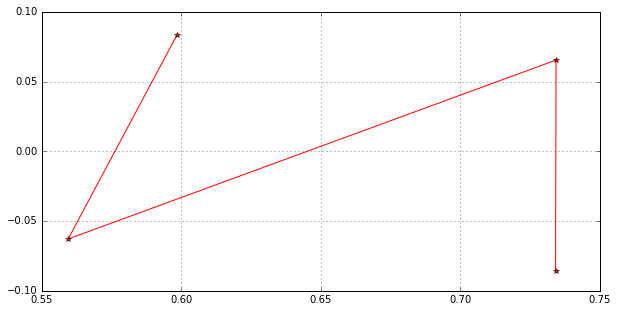

In [132]:
plt.figure(figsize=(10,5))
#plt.axis([6,8,-1,1])
plt.plot(dipole.d24[0,1,:],dipole.d24[0,0,:],'r-*')
#plt.plot(dipole.d24[1,1,:],dipole.d24[1,0,:],'b-*')
plt.grid()
plt.show()

In [158]:
seq=0
dipole.d24[seq,1,:]=1+dipole.d24[seq,1,:]
dipole.pos

array([ 6.1144    ,  1.23276996])

In [16]:
x0=0.1747
y0=44.8288
x1=0.9*(45-y0)/45*x0+x0
print x1

0.1752981728


## 参考粒子相位插值

In [3]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\_\\0deg-0deg-n30k'
os.chdir(workdir)

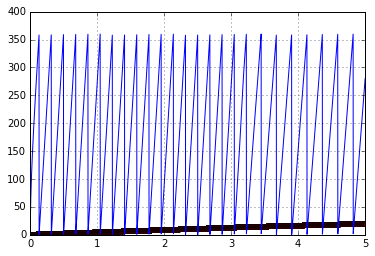

[ 310.90909091   27.36        308.88      ] [ -45.90909091  332.64         51.12      ]


In [6]:
data=np.loadtxt('ast.ref.001')
x=data[:,0] # m
y=data[:,1] # ns->deg: y=(y*1.3*360)%360
f=interp1d(x,(y*1.3*360)%360)
plt.plot(x,y,'r*',x,f(x),'b-')
plt.grid()
plt.show()

M1,M2=0.1965,0.1535
x1=[1.7,3.0+M1,3.8264+M2]
y1=f(x1)
y2=(y1*1.3*360)%360
print y2,-y2+[-95,0,0]+360

## 统计发射时丢失的粒子

In [5]:
workdir='E:\\Lixiangkun\\Work\\FEL-THz-exp\\20160801\\300kV-radial'
os.chdir(workdir)

In [6]:
sep=os.sep
rr=[]
for rt, dirs, files in os.walk('./'):
    for d in dirs:
        x=re.findall(r'[\d.]+',d)
        if x:
            r=x[0]
            #print d,r
            f=file(d+sep+'astra.log')
            ll=f.readlines()
            for l in ll:
                y=re.search(r'particles lost with z<Zmin',l)
                if y:
                    #print y.group()
                    p=re.findall(r'[\d.]+',l)
                    #print p[0]
                    rr.append([x[0],p[0]])
                    break
        #break
rr=np.array(rr)
#print rr
np.savetxt('lost.dat',rr,fmt='%12s')

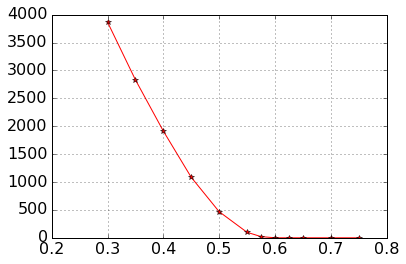

In [26]:
plt.plot(rr[:,0],rr[:,1],'r-*')
plt.grid()
plt.show()

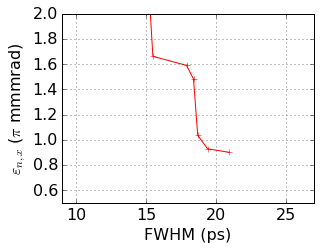

In [91]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\Injector-320kV'
os.chdir(workdir)

data=np.loadtxt('r35.sorted.by.length.out')
l0,r0=data[0,2],data[0,8]
r=[]
r.append([l0,r0])
for i in np.arange(1,len(data[:,0])):
    length=data[i,2]
    if length > l0:
        l0=length
        optimum=data[i,8]
        if optimum < r0:
            r0=optimum
            r.append([length,optimum])   
r=np.array(r)
np.savetxt('optimum.dat',r,fmt='%12.4E')
fig,axes=plt.subplots(figsize=(5,3.75))
axes.plot(r[:,0],r[:,1],'r-+')
axes.axis([9,27,0.5,2])
axes.set_xlabel('FWHM (ps)')
axes.set_ylabel('$\\varepsilon_{n,x}$ ($\pi$ mmmrad)')
axes.grid()
fig.subplots_adjust(bottom=0.2,left=0.2)
fig.savefig('optimum-gaussian.eps')

## 统计束流品质

In [9]:
workdir='E:\\Lixiangkun\\Work\\FEL-THz-exp\\20160715'
os.chdir(workdir)

In [4]:
sep=os.sep
row=50
rr=[] # dirname:4,xemi,xrms,zrms,DE
for rt, dirs, files in os.walk('./'):
    for d in dirs:
        x=re.findall(r'[\d.]+',d)
        if x:
            r1=np.zeros(5+5)
            #print d
            for i in np.arange(len(x)):
                r1[i]=float(x[i])
            data=np.loadtxt(d+sep+'ast.Xemit.001')
            if len(data)>0:
                r1[5],r1[6]=data[row,5],data[row,3]  #xemi,xrms
            data=np.loadtxt(d+sep+'ast.Zemit.001')
            if len(data)>0:
                r1[7],r1[8],r1[9]=data[row,3],data[row,4],data[row,2]  #zrms,del_E,E_kin
                rr.append(r1)
            #break
rr=np.array(rr)
#print rr
np.savetxt('beam.dat',rr,fmt='%12s')

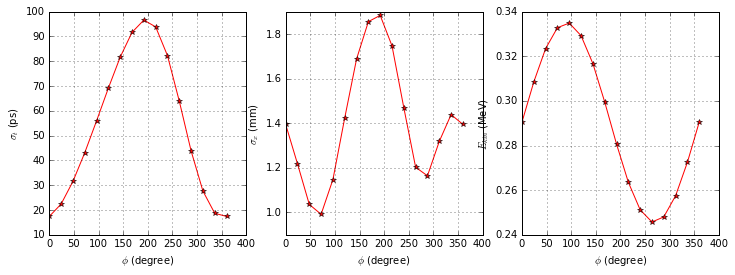

In [7]:
rr=np.loadtxt('beam.dat')
rr[:,0]=(rr[:,0])
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(12,4))
axes[0].plot(rr[:,0],rr[:,7]*4.33,'r-*')
axes[0].set_xlabel('$\phi$ (degree)')
axes[0].set_ylabel('$\sigma_t$ (ps)')
axes[0].grid()
axes[1].plot(rr[:,0],rr[:,6],'r-*')
axes[1].set_xlabel('$\phi$ (degree)')
axes[1].set_ylabel('$\sigma_x$ (mm)')
#axes[1].axis([-200,200,0.9,2])
axes[1].grid()
axes[2].plot(rr[:,0],rr[:,9],'r-*')
axes[2].set_xlabel('$\phi$ (degree)')
axes[2].set_ylabel('$E_{kin}$ (MeV)')
#axes[2].axis([-200,200,0.9,2])
axes[2].grid()
fig.savefig('100pC.eps')

In [69]:
float('4.4')

4.4

## 参数波动性分析

In [2]:
workdir='E:\\Lixiangkun\\Work\\THz-FEL-1\\320kV-gauss'
os.chdir(workdir)

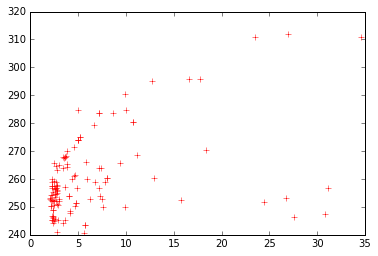

[  1.67100000e+02   2.50000000e-01   1.27550000e+00   2.56655000e+02
   1.18200000e+02   1.31855000e+02   9.02500000e-01   2.61505500e+00
   7.06940500e-01]
[ 18.08009956   0.4330127    0.02246664   6.22900273   2.24811032
   4.83068059   0.30185882   0.47743339   0.24798764]


In [102]:
data=np.loadtxt("r28.out9")
plt.plot(data[:,7],data[:,3],'r+')
plt.show()

sub=data[105:,:]
print np.mean(sub,0)
print np.std(sub,0)

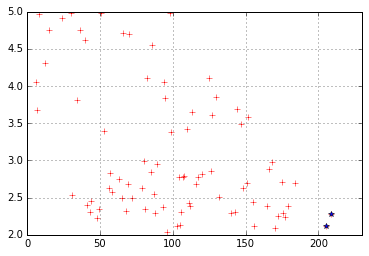

In [107]:
s0=np.array([ 1.275,256.6 , 118.2 , 131.8])
delta=0.0125
low=s0*(1-delta)
up=s0*(1+delta)

choice1=(data[:,2]>low[0])*(data[:,3]>low[1])*(data[:,4]>low[2])*(data[:,5]>low[3])
choice2=(data[:,2]< up[0])*(data[:,3]< up[1])*(data[:,4] <up[2])*(data[:,5] <up[3])
choice=choice1*choice2

n0=data[:,0]
e0=data[:,7]
nn=n0[choice]
ee=e0[choice]
plt.plot(n0,e0,'r+')
plt.plot(nn,ee,'b*')
plt.axis([0,230,2,5])
plt.grid()
plt.show()

In [82]:
choice=(data[:,7]<2.5)
s1=data[:,choice]

c:\python27\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 9 but corresponding boolean dimension is 221
  from ipykernel import kernelapp as app


IndexError: index 41 is out of bounds for axis 1 with size 9

254.2125 , 119.51875 , 129.29375
1.30330109721 1.55250553542 2.61497341048 

261.439160839 14.8153579121
114.13006993 10.8525916789
129.183916084 14.4362095753


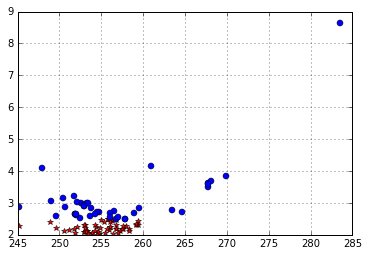

In [86]:
ss=data[:,3]
s11=ss[data[:,7]<=2.1]
ss=data[:,4]
s21=ss[data[:,7]<=2.1]
ss=data[:,5]
s31=ss[data[:,7]<=2.1]
print np.mean(s11),',',np.mean(s21),',',np.mean(s31)
print np.std(s11),np.std(s21),np.std(s31),'\n'

ss=data[:,3]
s12=ss[data[:,7]>2.5]
ss=data[:,4]
s22=ss[data[:,7]>2.5]
ss=data[:,5]
s32=ss[data[:,7]>2.5]
print np.mean(s12),np.std(s12)
print np.mean(s22),np.std(s22)
print np.mean(s32),np.std(s32)

plt.plot(x1,z1,'r*')
plt.plot(x2,z2,'bo')
plt.grid()
plt.show()

In [13]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [35]:
x=data[0:5,0:5]
x

array([[ 121.  ,    0.  ,    1.25,  254.7 ,  119.1 ],
       [ 122.  ,    1.  ,    1.25,  252.6 ,  119.3 ],
       [ 123.  ,    0.  ,    1.25,  258.3 ,  116.4 ],
       [ 124.  ,    2.  ,    1.42,  283.5 ,  103.6 ],
       [ 125.  ,    2.  ,    1.28,  247.9 ,  116.1 ]])

In [37]:
x[:,3]>250

array([ True,  True,  True,  True, False], dtype=bool)

In [79]:
a=np.array([1,2,3])
b=np.array([1,2,3])
a*b

array([1, 4, 9])